# Training example TPV 36 and 37 (3D)

TPV 36 and 37 are benchmark exercises that are designed to test if computer codes that simulate dynamic earthquake rupture are working as intended [(Harris et al., SRL 2018)](https://pubs.geoscienceworld.org/ssa/srl/article/89/3/1146/530061/A-Suite-of-Exercises-for-Verifying-Dynamic). It was designed by the [SCEC/USGS Spontaneous Rupture Code Verification Project](https://strike.scec.org/cvws/) and features:

* spontaneous rupture on a 2D planar 15-degree dipping thrust fault  
* homogeneous half-space: $V_p=6000\,m/s, V_s=3464\,m/s, \rho=2670\,kg/m^3$
* linear-slip weakening (LSW) friction 
* initial stress conditions are depth-dependent 

[Detailed benchmark description (SCEC)](https://strike.scec.org/cvws/tpv36_37docs.html).

# Off-fault receivers

In [11]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Prepare off-fault receivers for TPV upload

### For loop processing SeisSol receivers (off-fault)

In [13]:
# Folder where the processed receivers will be saved
output_folder = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR"
# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

VARIABLES = "Time","xx","yy","zz","xy","yz","xz","v1","v2","v3"
# VARIABLES = "Time","xx","yy","zz","xy","yz","xz","v1","v2","v3","damage","breakage" # needed for Zihua's branch
filenames = "*-receiver*.dat"

files = glob.glob(os.path.join("/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/TPV36_SCEC_v2_o4_David_RR/", filenames))
for f in files:
    # Coordinates 
    coords = pd.read_csv(f, nrows=3, skiprows=2, header=None, sep="\s+")
    x1 = coords[2][0]/1e3 # to km
    x2 = coords[2][1]/1e3
    x3 = coords[2][2]/1e3
    # Note: x3 replaced by 0.0 because receivers have been buried by 50 m
    print("\nx3 is {} km, but will use 0.0 km instead.".format(x3))
    x3 = 0.0
          
    if x2 < 0:
        file = "body{:03d}0st{:02d}0dp{:02d}0.csv".format(int(x2),int(x1),int(x3))
    else:
        file = "body{:02d}0st{:02d}0dp{:02d}0.csv".format(int(x2),int(x1),int(x3))
    print("Processing: ",file)
    print("Location = {:2.1f} km off-fault, {:2.1f} km along strike, {:2.1f} km depth".format(x2,x1,x3)) 
    
    # Off-fault receiver data
    df = pd.read_csv(f, skiprows=5, sep='\s+', names=VARIABLES)
    df['v3'] *= -1 # vertical component needs to be flipped
    time_step = df['Time'][1] - df['Time'][0]
    num_time_steps = len(df)
    print("Time step, length:", time_step, num_time_steps)
    df.drop(columns=["xx","yy","zz","xy","yz","xz"], inplace=True)
    # Integrate
    df["u1"] = np.cumsum(df['v1']) * time_step
    df["u2"] = np.cumsum(df['v2']) * time_step
    df["u3"] = np.cumsum(df['v3']) * time_step
    df.rename({"Time": "t", "v1": "h-vel", "u1": "h-disp", "v2": "n-vel", "u2": "n-disp", "v3": "v-vel", "u3": "v-disp"}, axis=1, inplace=True)
    df = df.loc[:,["t", "h-disp", "h-vel", "v-disp", "v-vel", "n-disp", "n-vel"]] # re-order columns
    tmp_receiver = os.path.join(output_folder, "tmp_receiver.csv")
    receiver = os.path.join(output_folder, file)
    df.to_csv(tmp_receiver, index=False, sep=" ", float_format="%.7e")

    # Content with placeholders for the values
    file_content = """# problem = TPV36
# author = Fabian Kutschera
# date = 2024/10/05
# code = SeisSol
# code_version = v1.1.4-402-g8cddb43c (dirty) 
# element_size = 200.0 m (o4)
# time_step = {} (s)
# num_time_steps = {}
# location = {:2.1f} km off-fault, {:2.1f} km along strike, {:2.1f} km depth
# Column #1 = Time (s)
# Column #2 = horizontal displacement (m)
# Column #3 = horizontal velocity (m/s)
# Column #4 = vertical displacement (m)
# Column #5 = vertical velocity (m/s)
# Column #6 = normal displacement (m)
# Column #7 = normal velocity (m/s)
#
# The line below lists the names of the data fields:
"""
    
    # Format the string 
    formatted_content = file_content.format(time_step, num_time_steps, x2, x1, x3)
    
    # Full path to the file
    tmp_file = os.path.join(output_folder, "tmp.txt")
    
    # Write the formatted content to the file
    with open(tmp_file, 'w') as file:
        file.write(formatted_content)
    
    !echo "$tmp_file" "$tmp_receiver" "$receiver"
    !cat "$tmp_file" "$tmp_receiver" > "$receiver"
    !rm "$tmp_file" "$tmp_receiver"


x3 is -0.05 km, but will use 0.0 km instead.
Processing:  body330st000dp000.csv
Location = 33.0 km off-fault, 0.0 km along strike, 0.0 km depth
Time step, length: 0.005 4401
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/tmp.txt /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/tmp_receiver.csv /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body330st000dp000.csv

x3 is -0.05 km, but will use 0.0 km instead.
Processing:  body-010st100dp000.csv
Location = -1.0 km off-fault, 10.0 km along strike, 0.0 km depth
Time step, length: 0.005 4401
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/tmp.txt /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/tmp_receiver.csv /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body-010st100dp000.csv

x3 is -0.05 km, but will use 0.0 km instead.
Processin

### Plot all processed receivers (off-fault) to compare against TPV results 

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body-090st100dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body-090st100dp000.dat


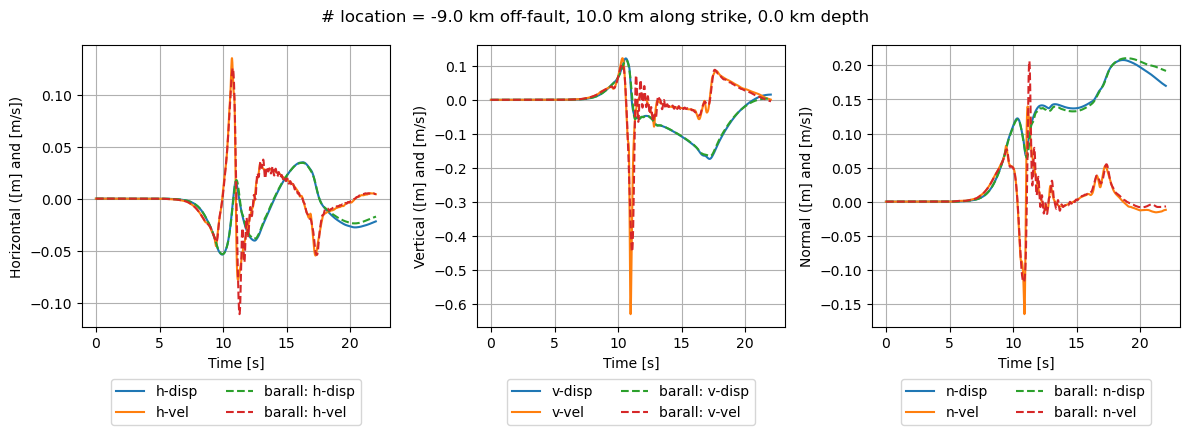

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body-010st100dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body-010st100dp000.dat


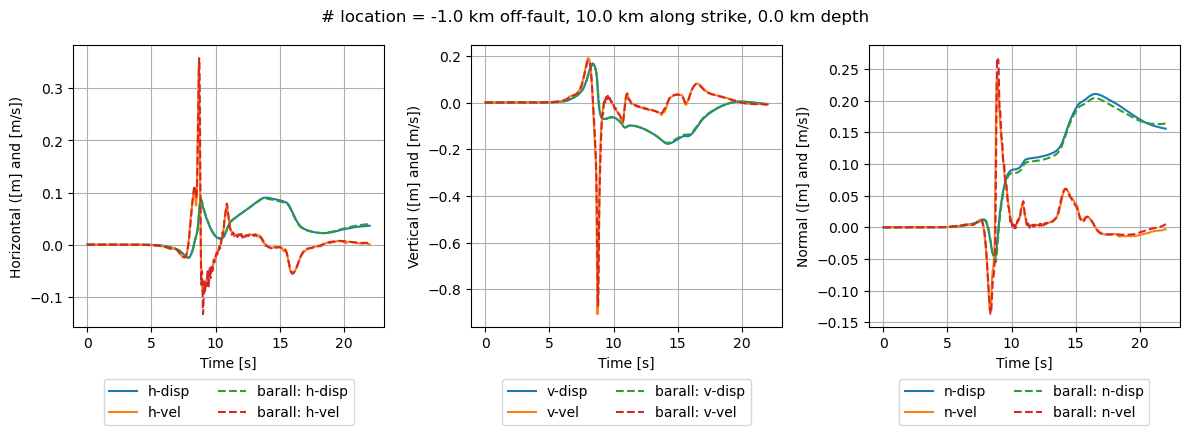

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body450st200dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body450st200dp000.dat


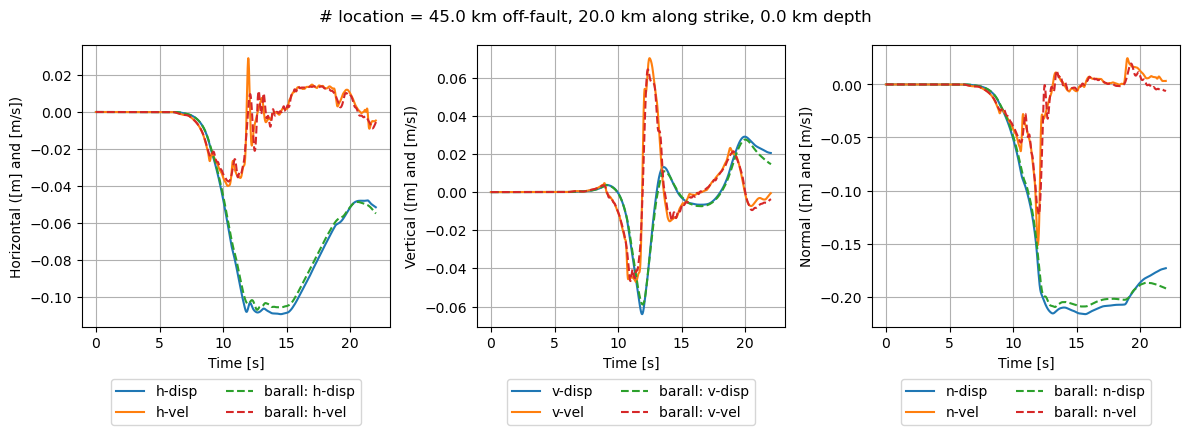

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body090st100dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body090st100dp000.dat


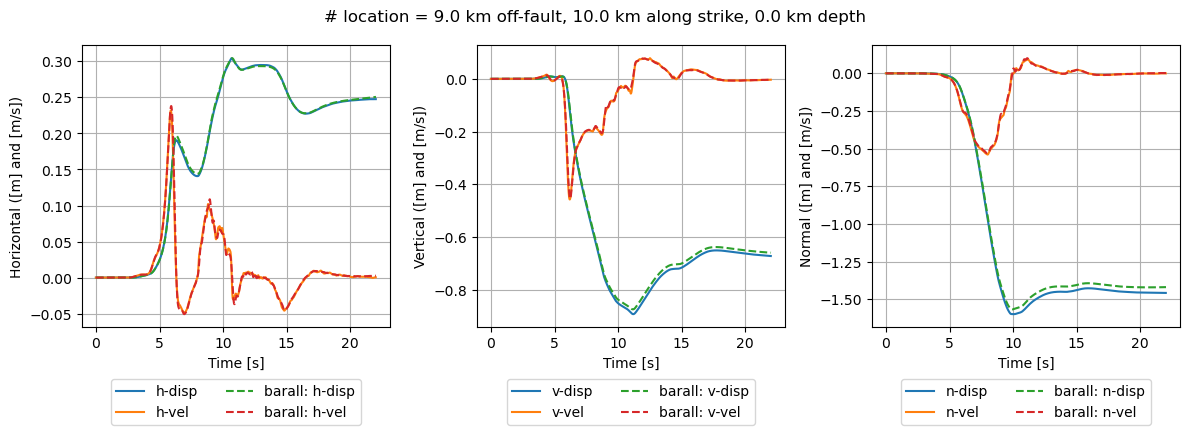

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body270st200dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body270st200dp000.dat


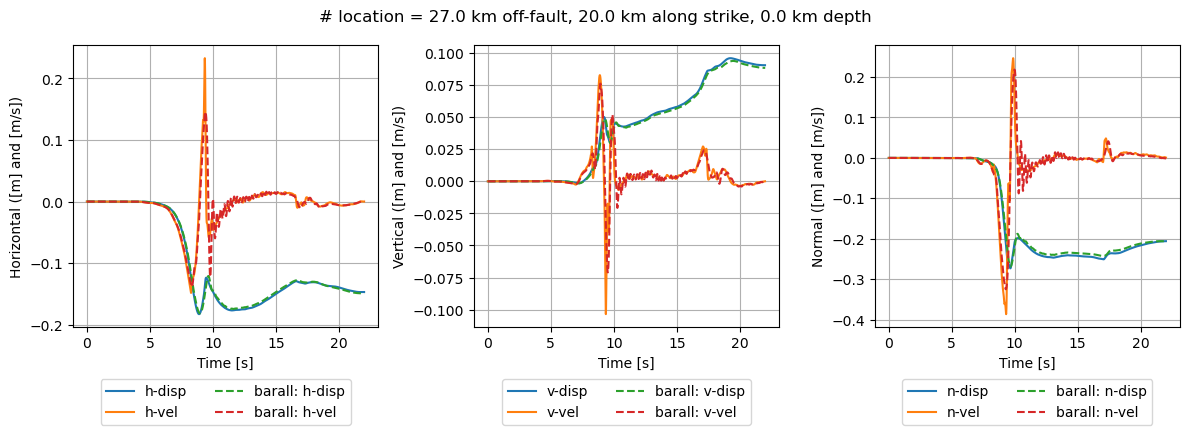

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body390st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body390st000dp000.dat


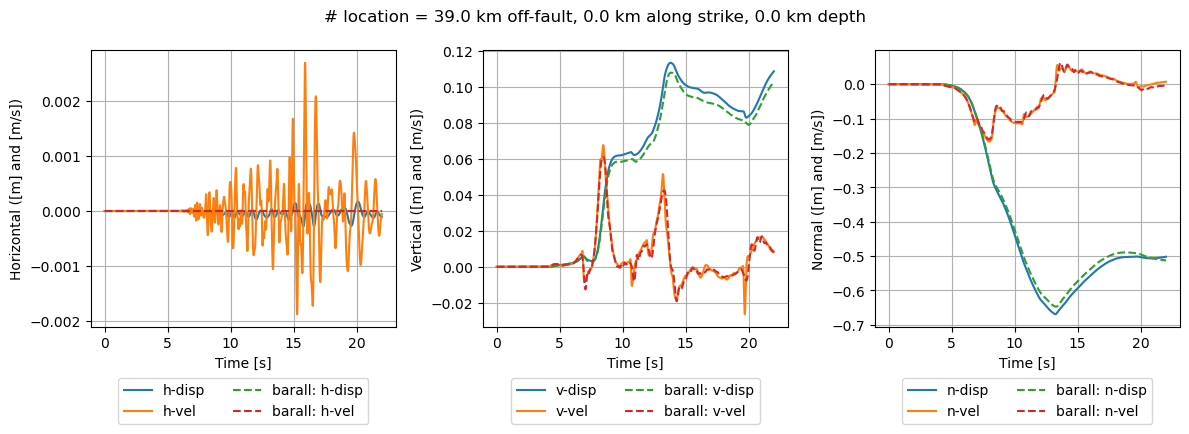

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body010st100dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body010st100dp000.dat


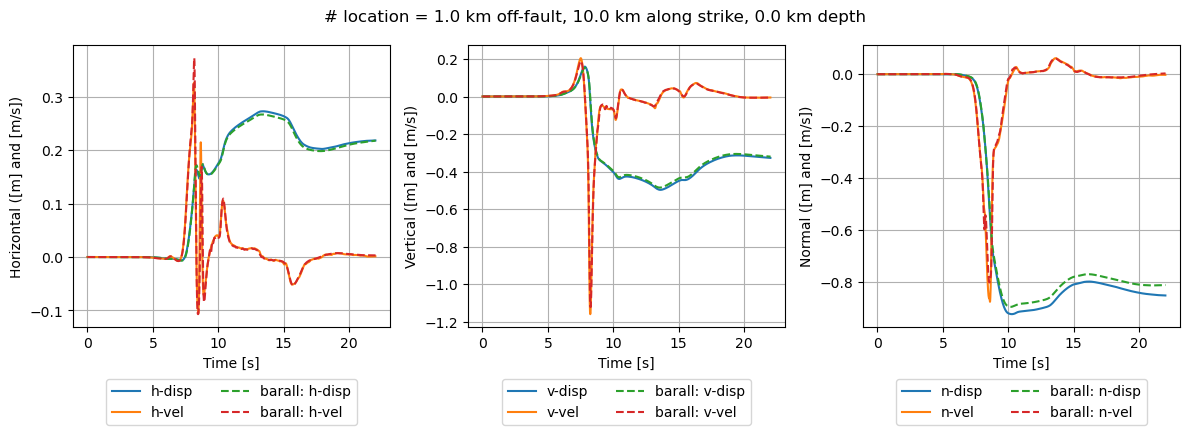

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body330st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body330st000dp000.dat


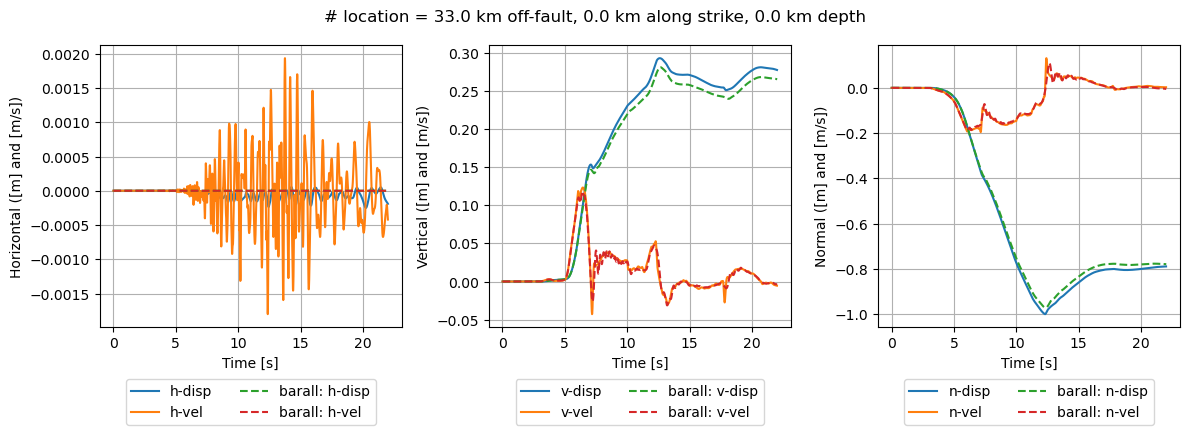

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body210st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body210st000dp000.dat


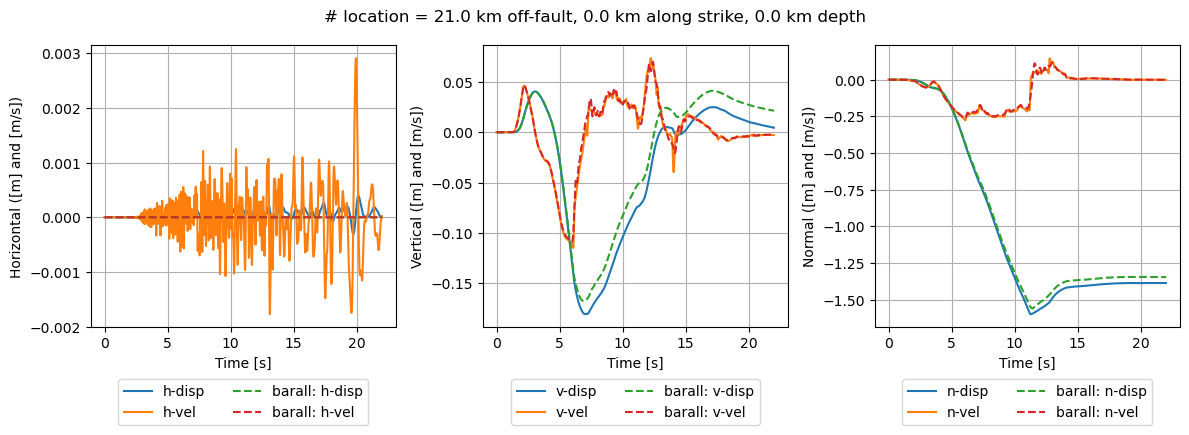

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body450st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body450st000dp000.dat


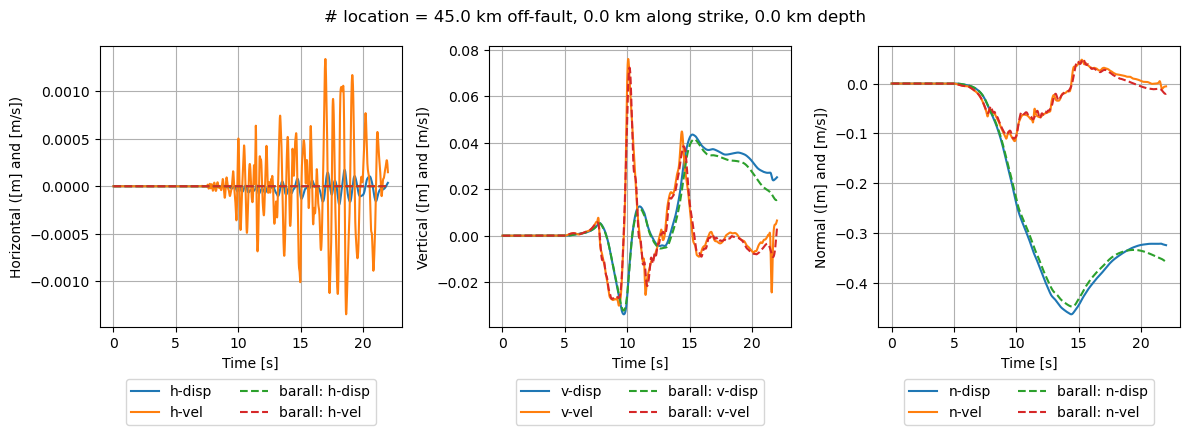

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body270st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body270st000dp000.dat


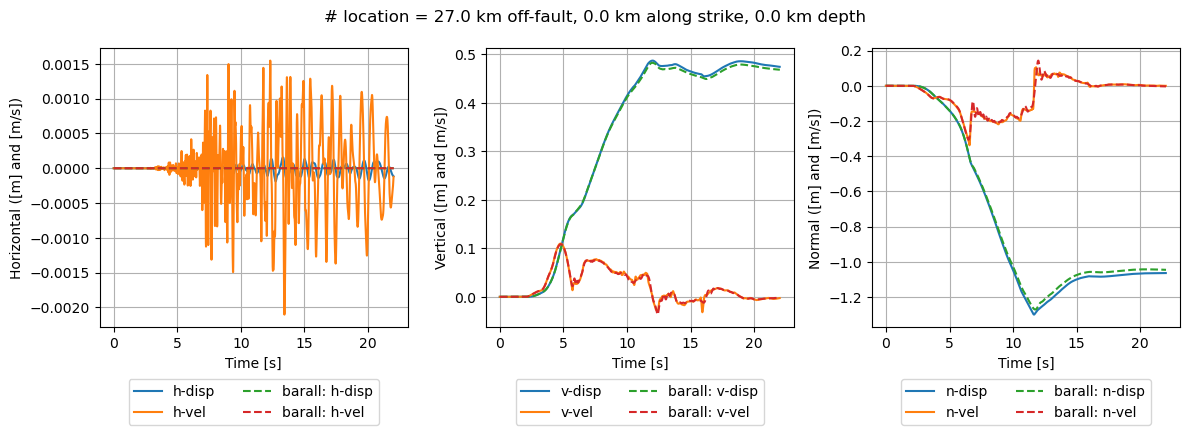

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body090st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body090st000dp000.dat


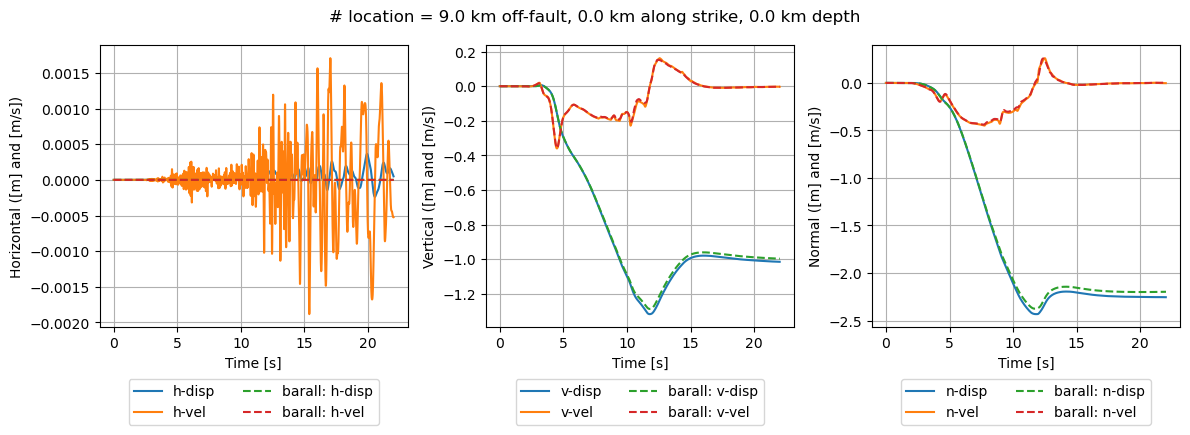

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body010st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body010st000dp000.dat


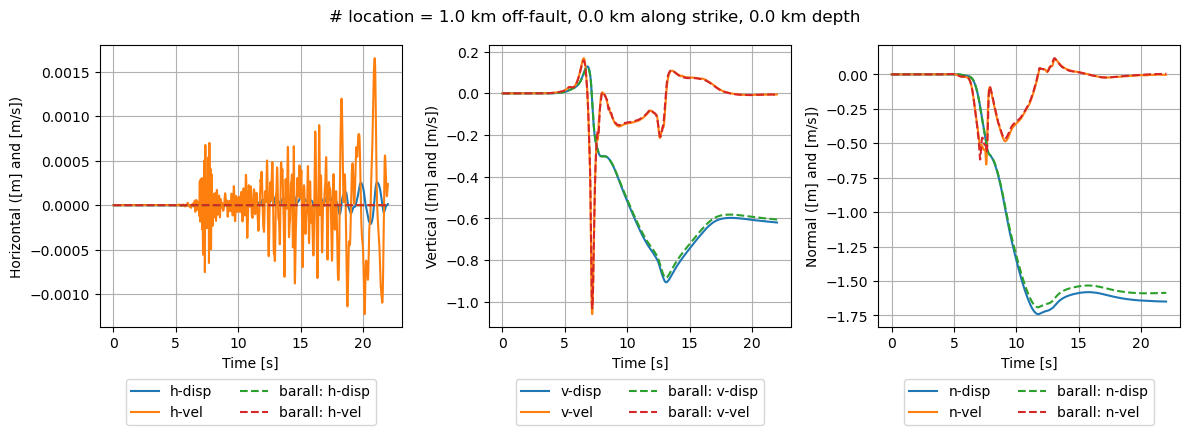

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body150st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body150st000dp000.dat


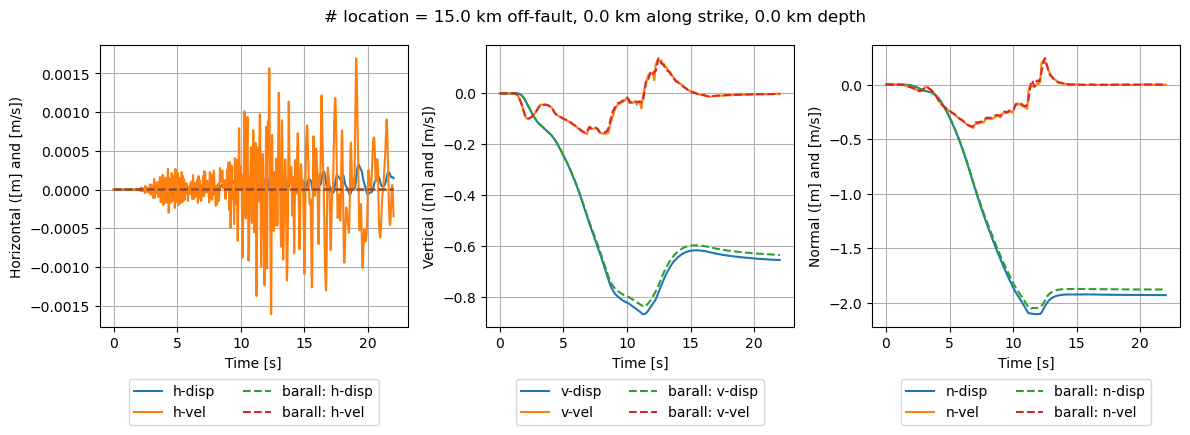

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body-090st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body-090st000dp000.dat


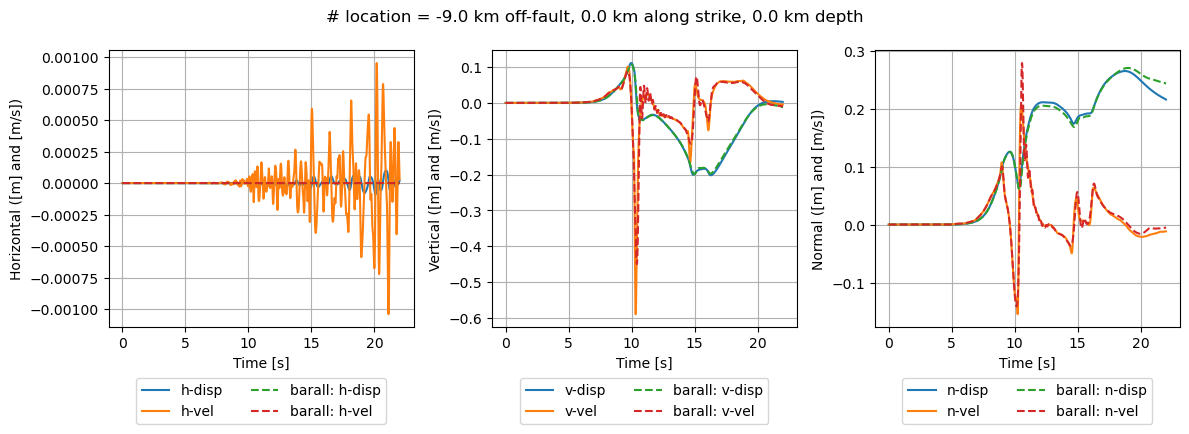

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body-010st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body-010st000dp000.dat


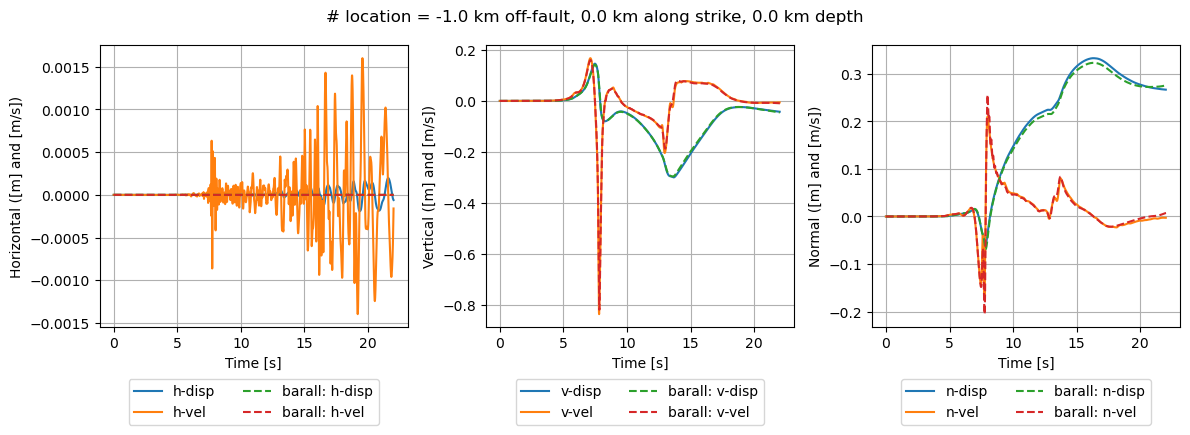

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body-030st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body-030st000dp000.dat


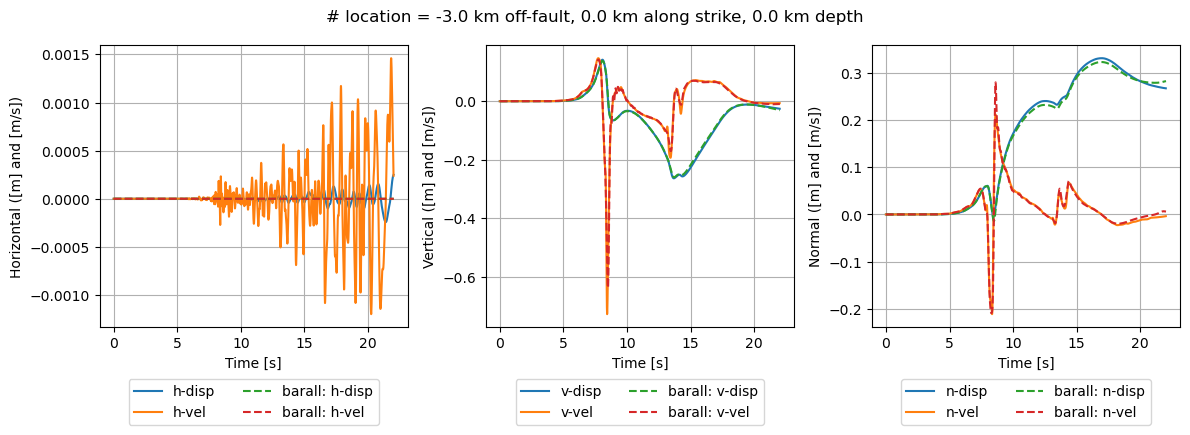

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body090st200dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body090st200dp000.dat


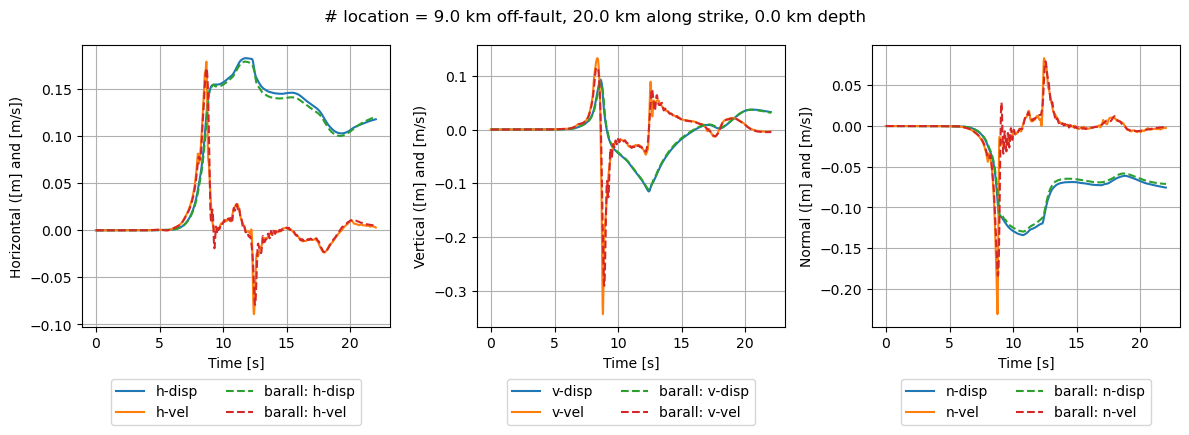

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body270st100dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body270st100dp000.dat


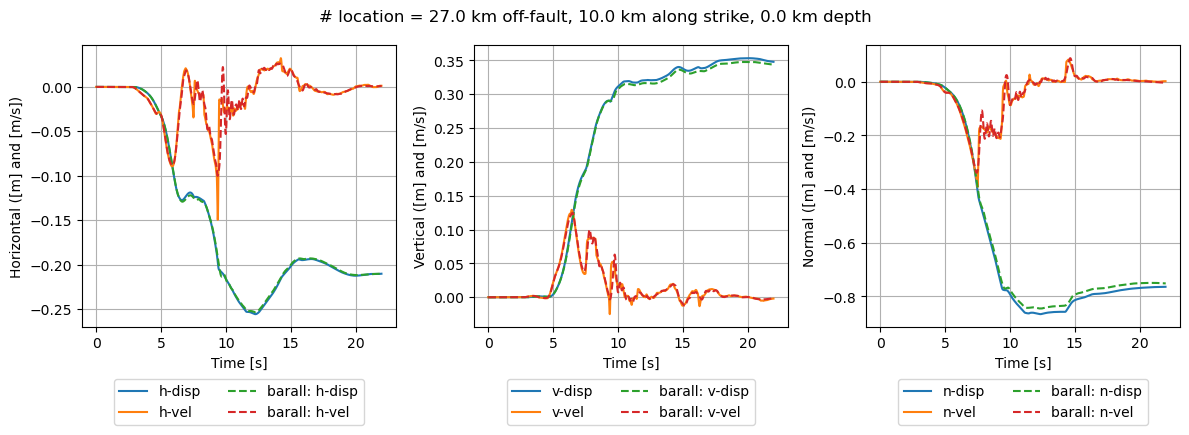

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body-090st200dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body-090st200dp000.dat


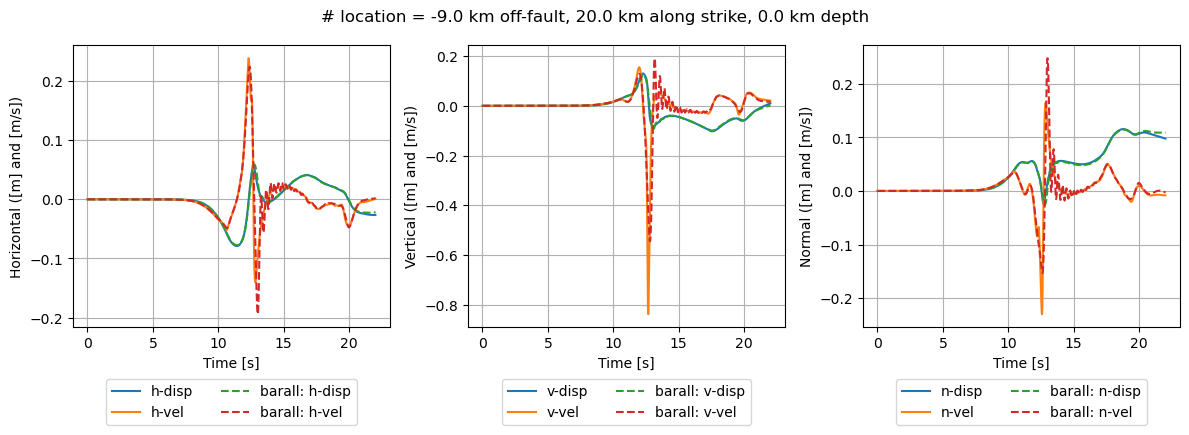

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body030st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body030st000dp000.dat


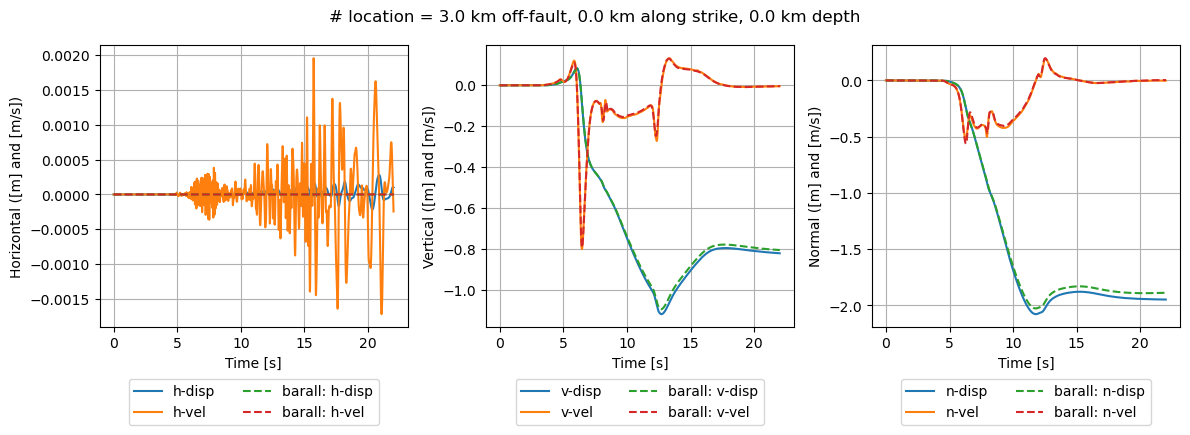

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/body450st100dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body450st100dp000.dat


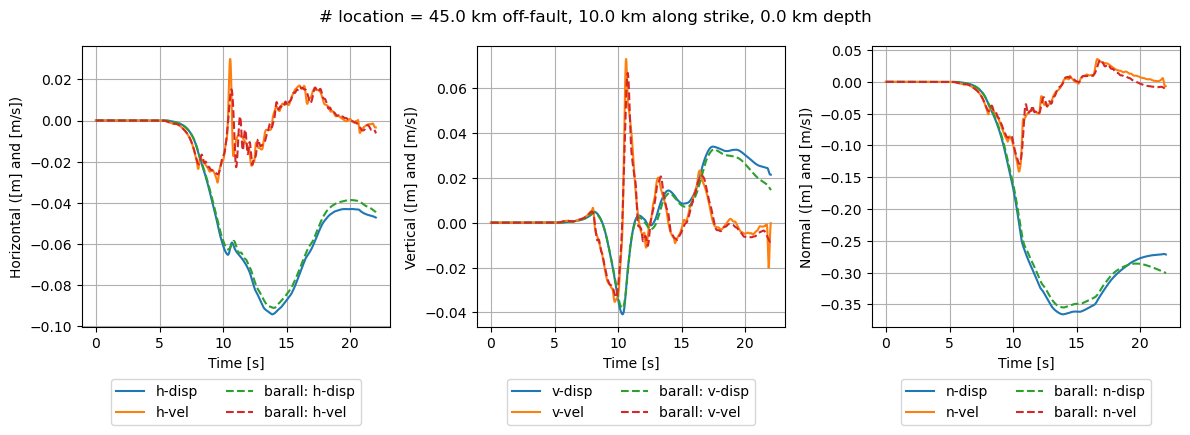

In [14]:
filenames = "body*.csv"

files = glob.glob(os.path.join(output_folder, filenames))

for f in files:
    print(f)

    df_title = pd.read_csv(f, skiprows=8, nrows=1, sep=";", header=None) #arbitray separator
    title = df_title.iloc[0][0]
    
    df = pd.read_csv(f, sep="\s+", comment="#")
    if len(f.split('-')) > 1:
        f_barall = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/"+f[-22:-4]+".dat"
    else:
        f_barall = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/"+f[-21:-4]+".dat"
    print(f_barall)
    barall = pd.read_csv(f_barall, sep="\s+", comment="#") 
    
    # Create figure and subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))
    fig.suptitle(title)

    # Plot xx, yy, zz, xy, yz, xz on ax1
    ax1.plot(df["t"], df["h-disp"], label="h-disp")
    ax1.plot(df["t"], df["h-vel"], label="h-vel")
    ax1.plot(barall["t"], barall["h-disp"], label="barall: h-disp", linestyle="dashed")
    ax1.plot(barall["t"], barall["h-vel"], label="barall: h-vel", linestyle="dashed")
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Horizontal ([m] and [m/s])")
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
    ax1.grid(True)

    # Plot v1, v2, v3 on ax2
    ax2.plot(df["t"], df["v-disp"], label="v-disp")
    ax2.plot(df["t"], df["v-vel"], label="v-vel")
    ax2.plot(barall["t"], barall["v-disp"], label="barall: v-disp", linestyle="dashed")
    ax2.plot(barall["t"], barall["v-vel"], label="barall: v-vel", linestyle="dashed")
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Vertical ([m] and [m/s])")
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
    ax2.grid(True)

    # Plot displacements
    ax3.plot(df["t"], df["n-disp"], label="n-disp")
    ax3.plot(df["t"], df["n-vel"], label="n-vel")
    ax3.plot(barall["t"], barall["n-disp"], label="barall: n-disp", linestyle="dashed")
    ax3.plot(barall["t"], barall["n-vel"], label="barall: n-vel", linestyle="dashed")
    ax3.set_xlabel("Time [s]")
    ax3.set_ylabel("Normal ([m] and [m/s])")
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
    ax3.grid(True)

    # Adjust layout and display
    plt.tight_layout()
    if len(f.split('-')) > 1:
        fig.savefig(output_folder + "/" + f[-22:-4] + ".png", dpi=300)
    else:
        fig.savefig(output_folder + "/" + f[-21:-4] + ".png", dpi=300)
    plt.show()

## Prepare on-fault receivers for TPV upload

### For loop processing SeisSol receivers (on-fault)

In [19]:
# Folder where the processed receivers will be saved
output_folder = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/"
# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

VARIABLES = "Time" ,"SRs" ,"SRd" ,"T_s" ,"T_d" ,"P_n" ,"u_n" ,"Mud" ,"StV" ,"Ts0" ,"Td0" ,"Pn0" ,"Sls" ,"Sld" ,"Vr" ,"ASl" ,"PSR" ,"RT" ,"DS" ,"P_f" ,"Tmp"
filenames = "*-faultreceiver*.dat"

files = glob.glob(os.path.join("/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/TPV36_SCEC_v2_o4_David_RR/", filenames))
for f in files:
    # Coordinates 
    coords = pd.read_csv(f, nrows=3, skiprows=2, header=None, sep="\s+")
    x1 = coords[2][0]/1e3 # to km
    x2 = coords[2][1]/1e3
    x3 = coords[2][2]/1e3
    w = abs(x3 / np.sin(15*np.pi / 180)) 
    # Note: top-most (free surface) on-fault receivers have been buried by ~50 m
    if w < 0.1:
        w = 0.0
    
    file = "faultst{:02d}0dp{:02d}0.csv".format(int(x1),int(w))
    print("\nProcessing: ",file)
    print("Location = {:2.1f} km off-fault, {:2.1f} km along strike, {:2.1f} km depth".format(x2,x1,x3))
    print("Location = {:2.1f} km along strike, {:2.1f} km along-dip".format(int(x1),int(w)))
    
    # On-fault receiver data
    df = pd.read_csv(f, skiprows=5, sep='\s+', names=VARIABLES)
    df["Sld"] *= -1 # vertical component needs to be flipped
    df["SRd"] *= -1 
    df["Td0"] *= -1e-6 # MPa in SCEC 
    df["T_d"] *= -1e-6 
    df["Ts0"] *= 1e-6 
    df["T_s"] *= 1e-6 
    df["Pn0"] *= 1e-6
    df["P_n"] *= 1e-6 

    # Resampling time of non-uniform fault receiver is necessary to upload to SCEC
    #time_step = df["Time"][1] - df["Time"][0]
    num_time_steps = len(df)
    resampled_time = np.linspace(start=0.0, stop=22.0, num=num_time_steps, endpoint=True)
    df["Time"] = resampled_time
    time_step = df["Time"][1] - df["Time"][0]
    
    print("Time step, length:", time_step, num_time_steps)
    df.drop(columns=["T_s" ,"T_d" ,"P_n" ,"u_n" ,"Mud" ,"StV", "Vr" ,"ASl" ,"PSR" ,"RT" ,"DS" ,"P_f" ,"Tmp"], inplace=True)
    df.rename({"Time": "t", "Sls": "h-slip", "SRs": "h-slip-rate", "Ts0": "h-shear-stress", 
               "Sld": "v-slip", "SRd": "v-slip-rate", "Td0": "v-shear-stress", "Pn0": "n-stress"}, axis=1, inplace=True)
    df = df.loc[:,["t", "h-slip", "h-slip-rate", "h-shear-stress", "v-slip", "v-slip-rate", "v-shear-stress", "n-stress"]] # re-order columns
    tmp_receiver = os.path.join(output_folder, "tmp_receiver.csv")
    receiver = os.path.join(output_folder, file)
    df.to_csv(tmp_receiver, index=False, sep=" ", float_format="%.7e")

    # Content with placeholders for the values
    file_content = """# problem = TPV36
# author = Fabian Kutschera
# date = 2024/10/05
# code = SeisSol
# code_version = v1.1.4-402-g8cddb43c (dirty) 
# element_size = 200.0 m (o4)
# time_step = {} (s)
# num_time_steps = {}
# location = {:2.1f} km along strike, {:2.1f} km down-dip
# Column #1 = Time (s)
# Column #2 = horizontal (along-strike) slip (m)
# Column #3 = horizontal (along-strike) slip rate (m/s)
# Column #4 = horizontal (along-strike) shear stress (MPa)
# Column #5 = along-dip slip (m)
# Column #6 = along-dip slip rate (m/s)
# Column #7 = along-dip shear stress (MPa)
# Column #8 = normal stress (MPa)
#
"""
    
    # Format the string 
    formatted_content = file_content.format(time_step, num_time_steps, x1, abs(np.round(w)))
    
    # Full path to the file
    tmp_file = os.path.join(output_folder, "tmp.txt")
    
    # Write the formatted content to the file
    with open(tmp_file, 'w') as file:
        file.write(formatted_content)
    
    !echo "$tmp_file" "$tmp_receiver" "$receiver"
    !cat "$tmp_file" "$tmp_receiver" > "$receiver"
    !rm "$tmp_file" "$tmp_receiver"


Processing:  faultst000dp000.csv
Location = 0.2 km off-fault, 0.0 km along strike, -0.1 km depth
Location = 0.0 km along strike, 0.0 km along-dip
Time step, length: 0.00023912003825920613 92005
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/tmp.txt /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/tmp_receiver.csv /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst000dp000.csv

Processing:  faultst080dp000.csv
Location = 0.2 km off-fault, 8.0 km along strike, -0.1 km depth
Location = 8.0 km along strike, 0.0 km along-dip
Time step, length: 0.00023912003825920613 92005
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/tmp.txt /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/tmp_receiver.csv /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst080dp000.csv

Processing:  faultst0

### Plot all processed receivers (on-fault) to compare against TPV results

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst000dp180.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp180.dat


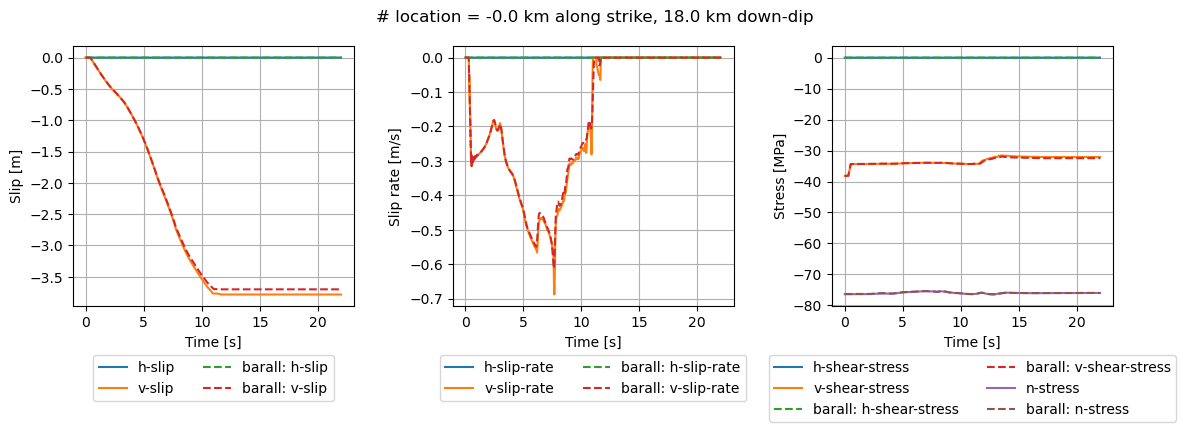

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst120dp030.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst120dp030.dat


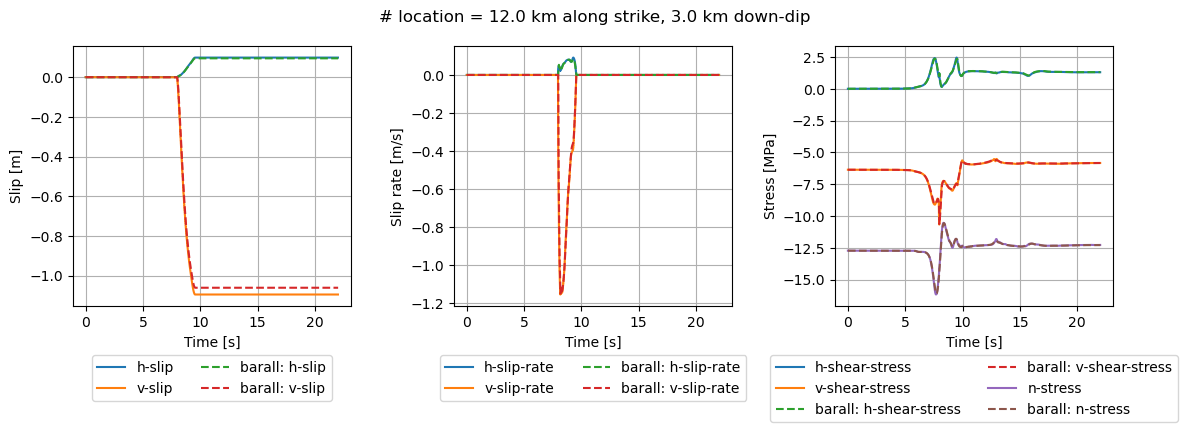

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst000dp030.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp030.dat


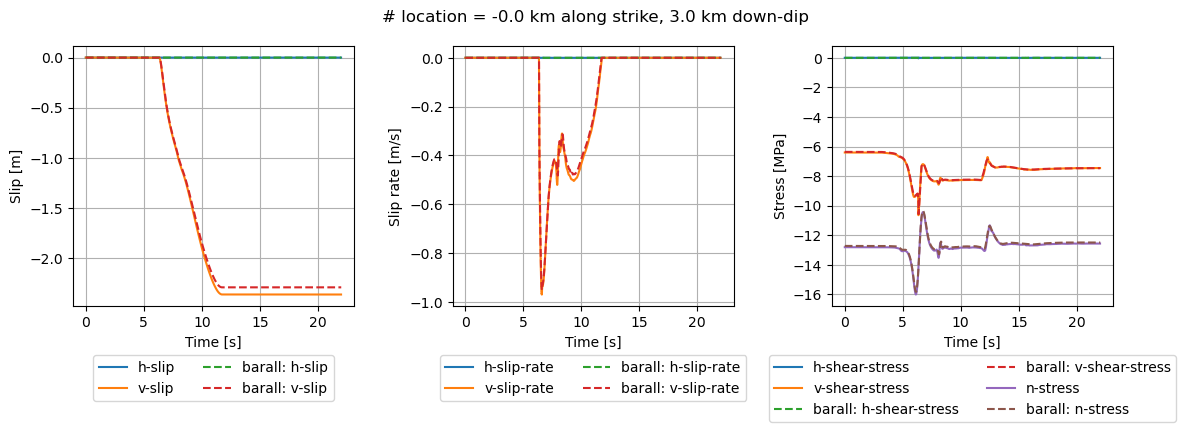

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst040dp060.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst040dp060.dat


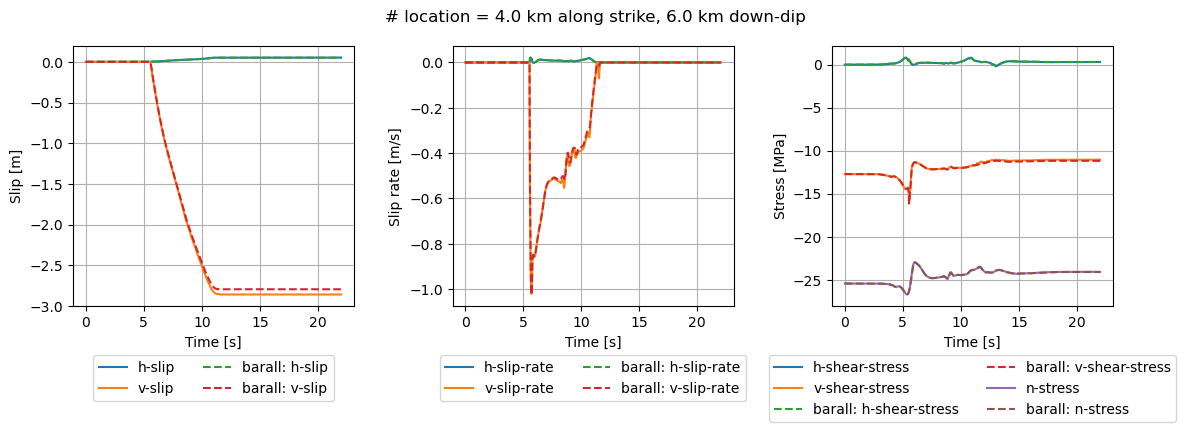

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst120dp180.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst120dp180.dat


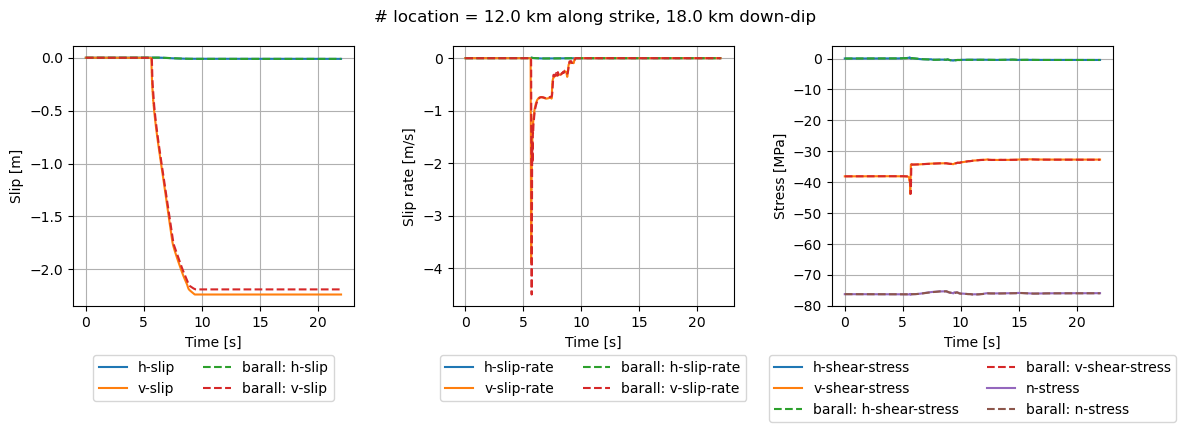

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst080dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst080dp000.dat


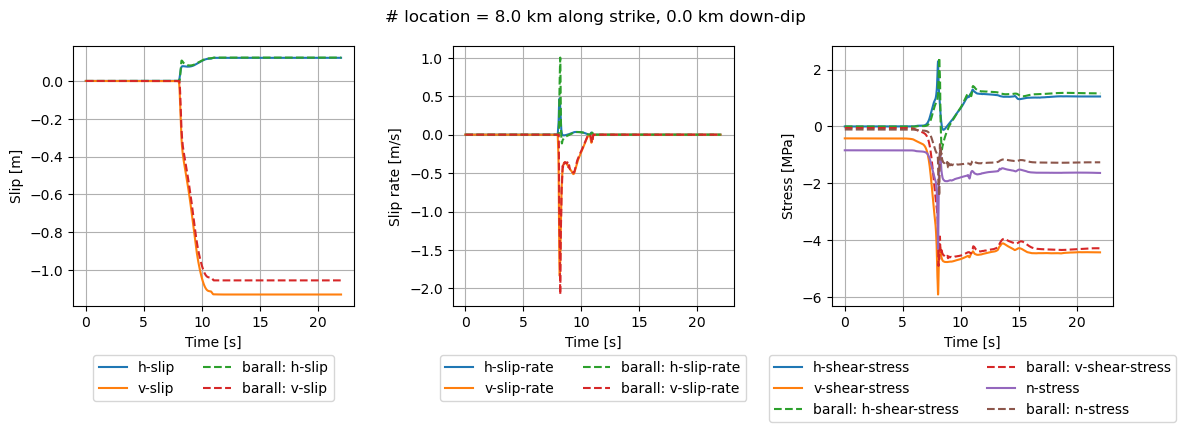

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst000dp120.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp120.dat


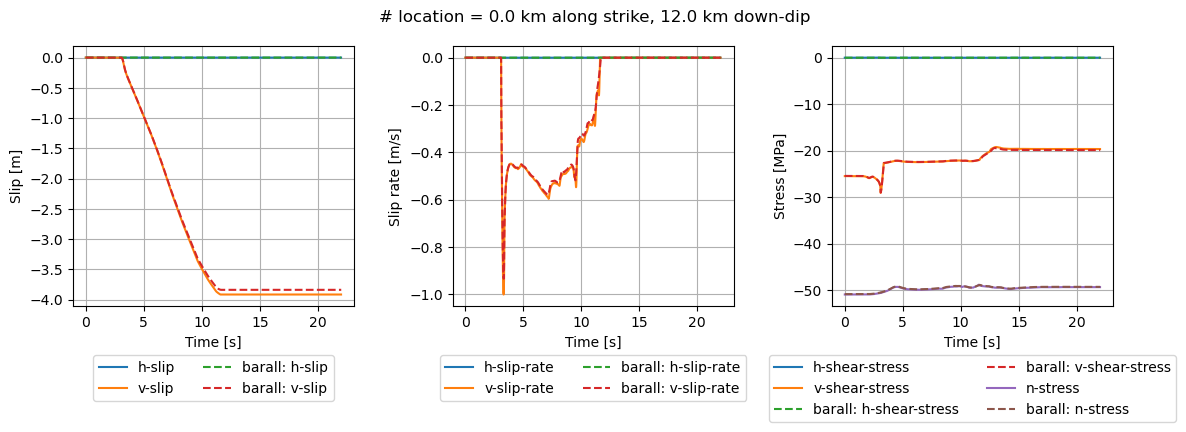

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst000dp240.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp240.dat


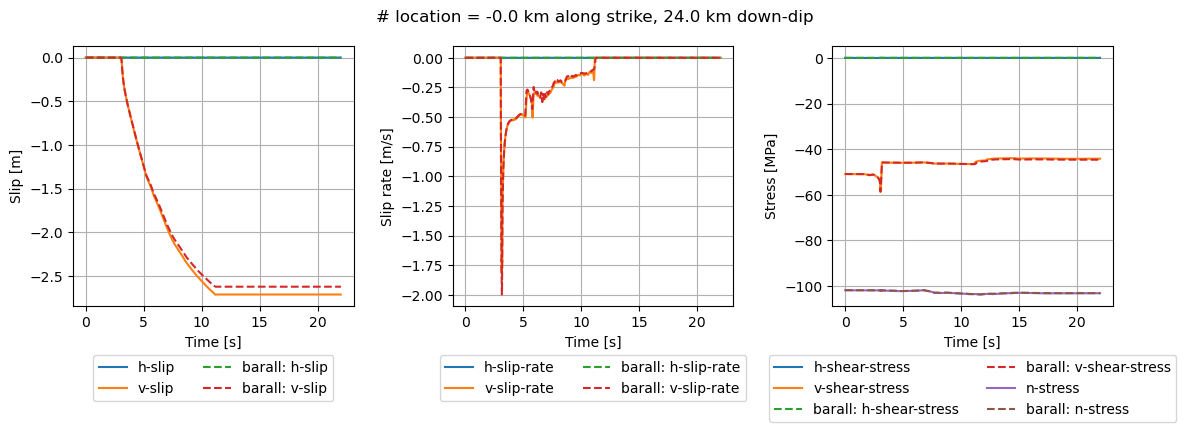

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst120dp120.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst120dp120.dat


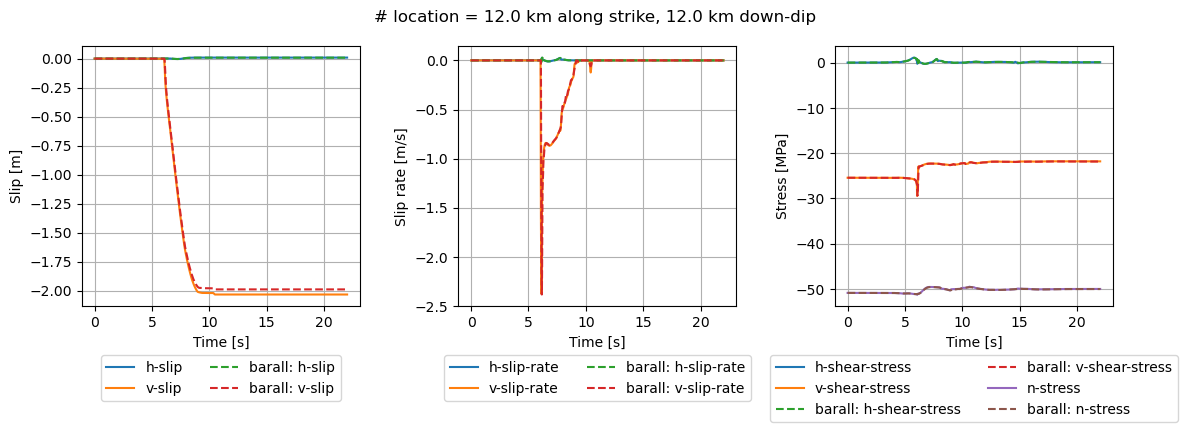

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst040dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst040dp000.dat


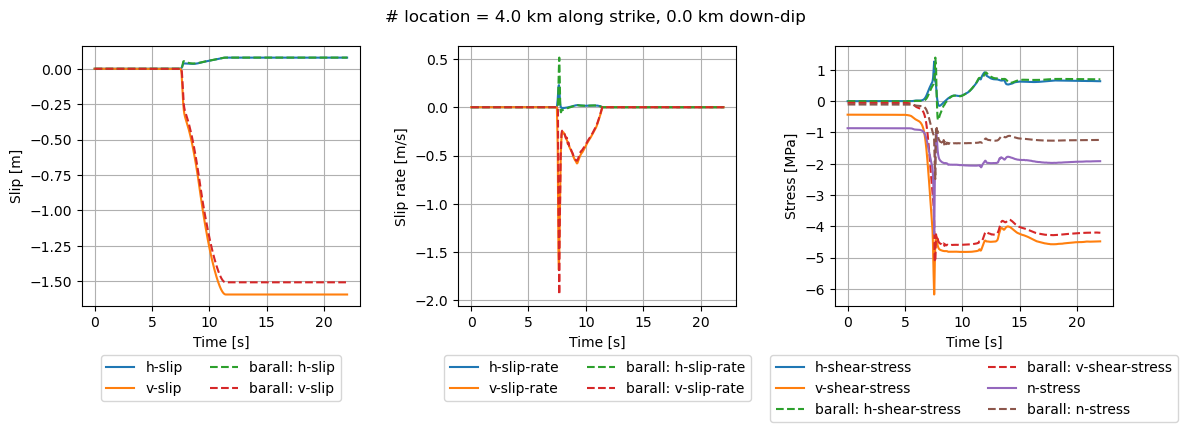

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst080dp060.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst080dp060.dat


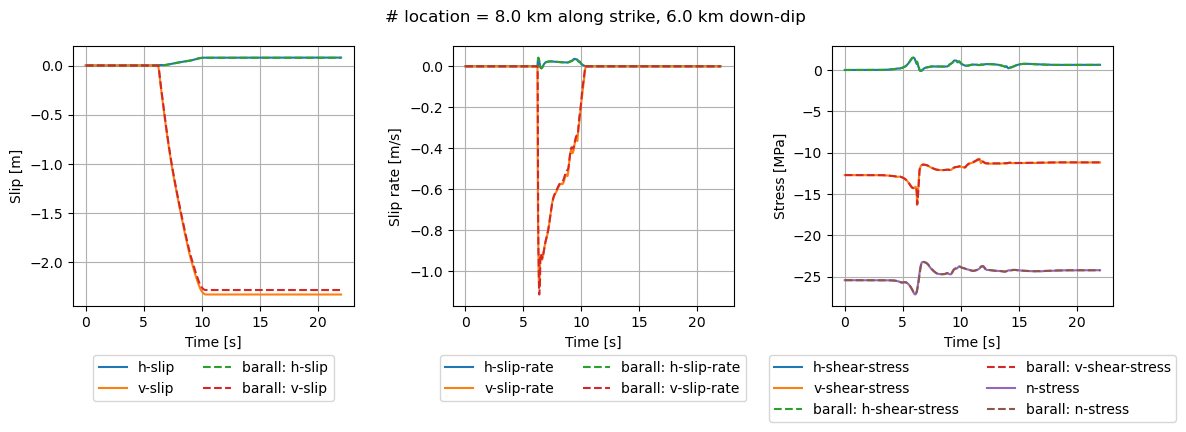

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst000dp060.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp060.dat


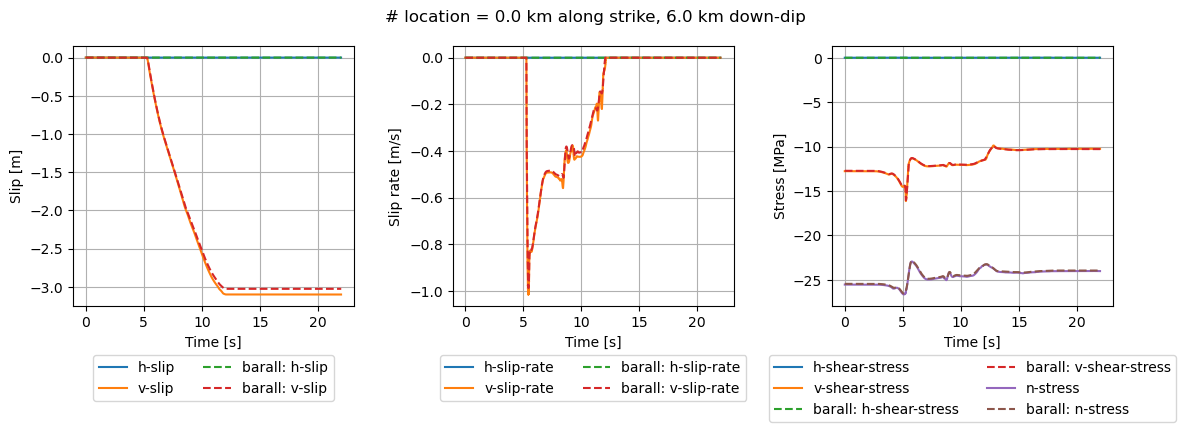

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst040dp030.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst040dp030.dat


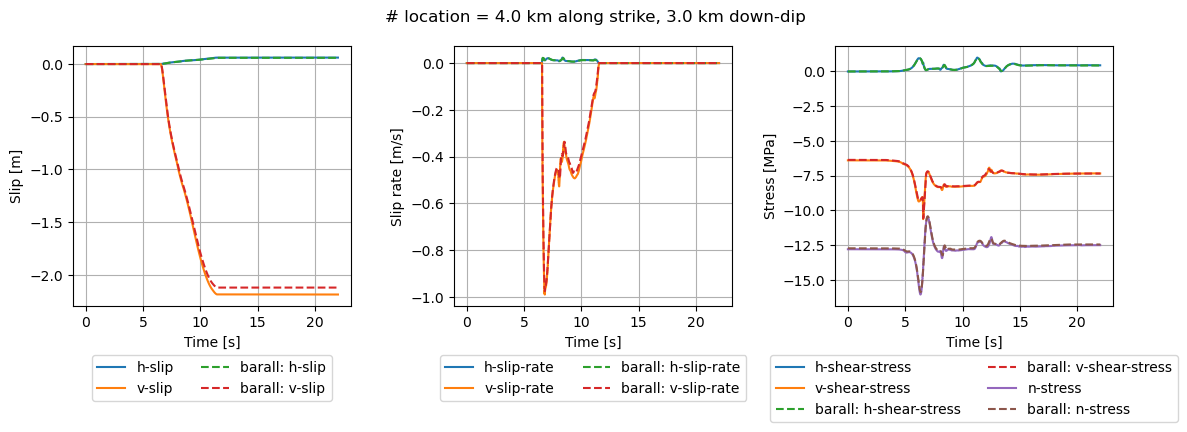

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst040dp180.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst040dp180.dat


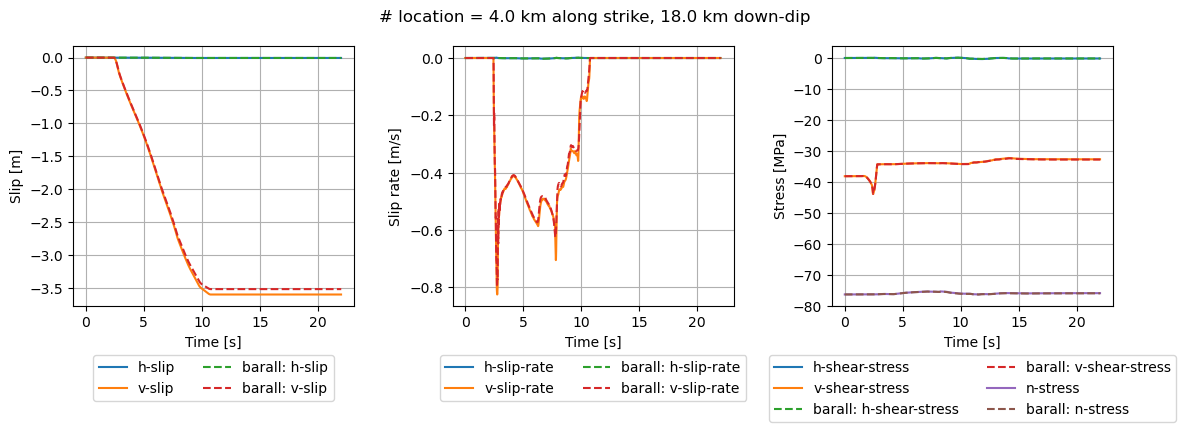

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst120dp060.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst120dp060.dat


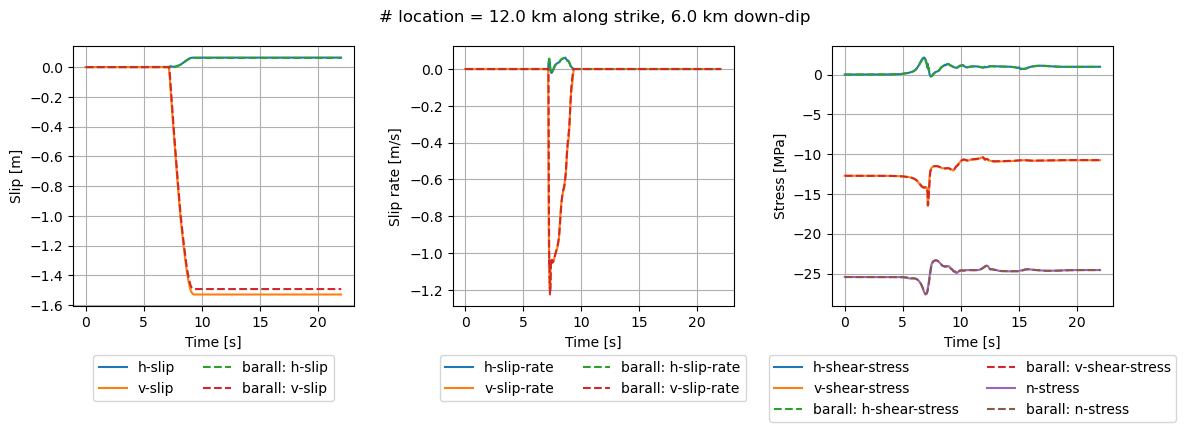

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst080dp120.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst080dp120.dat


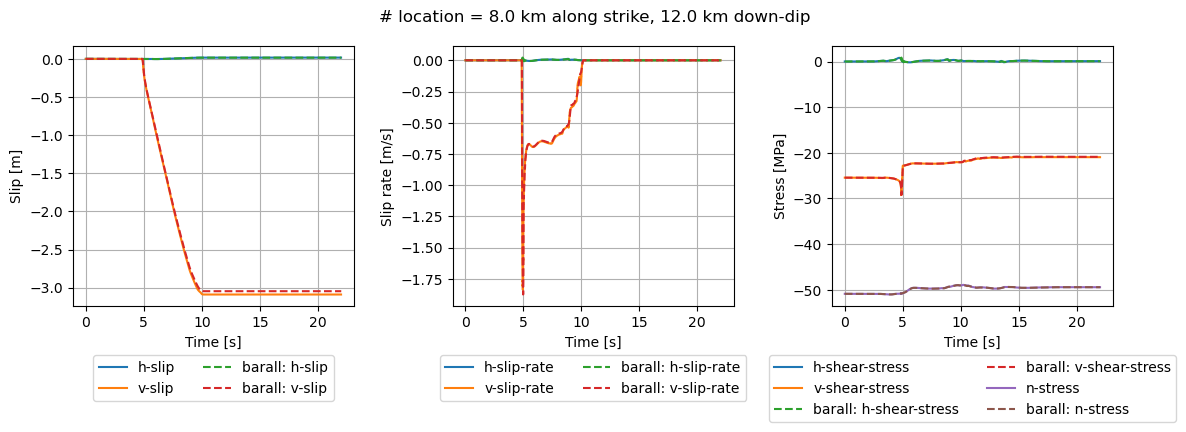

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp000.dat


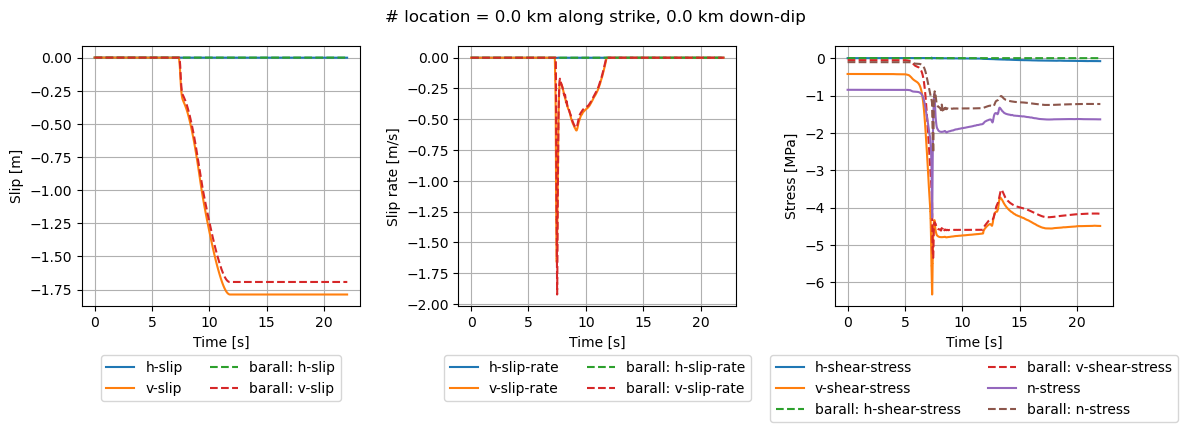

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst080dp030.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst080dp030.dat


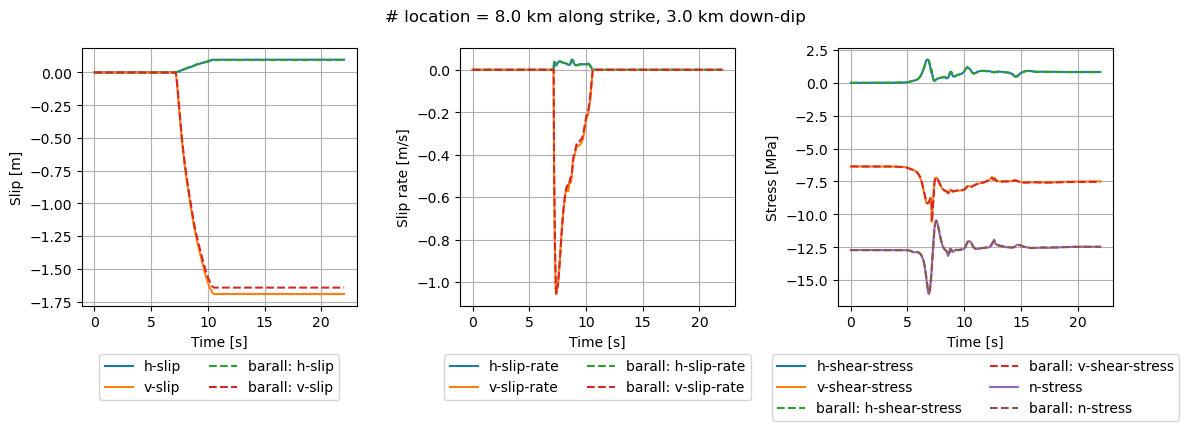

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst040dp120.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst040dp120.dat


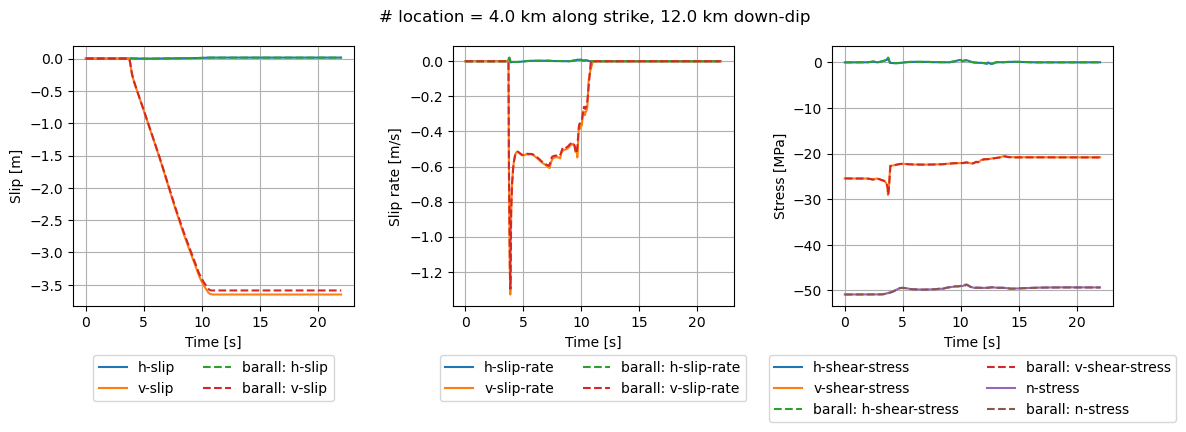

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst000dp010.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp010.dat


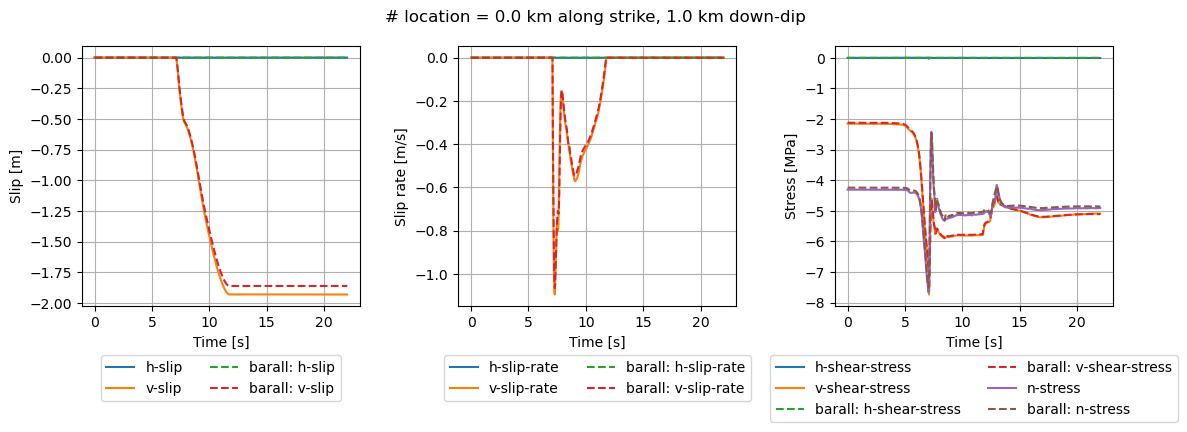

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst120dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst120dp000.dat


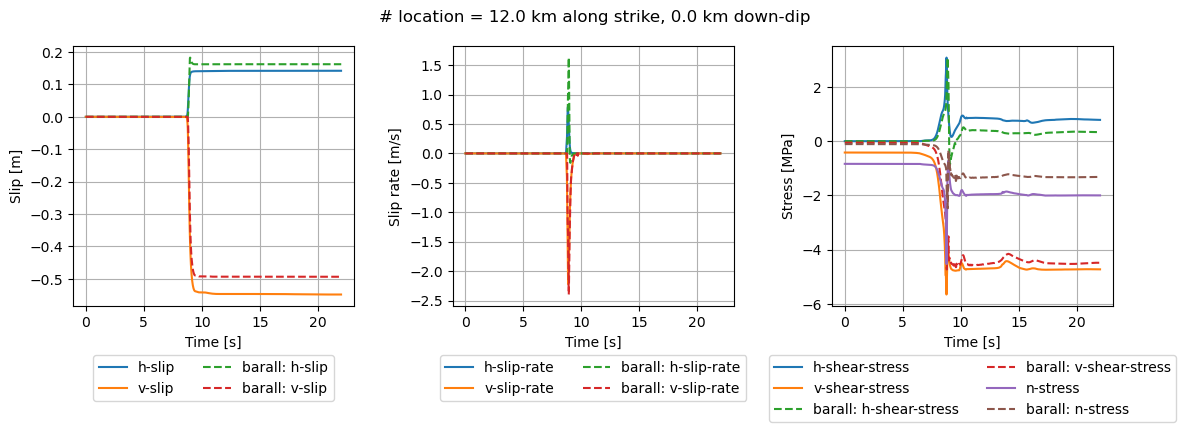

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/faultst080dp180.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst080dp180.dat


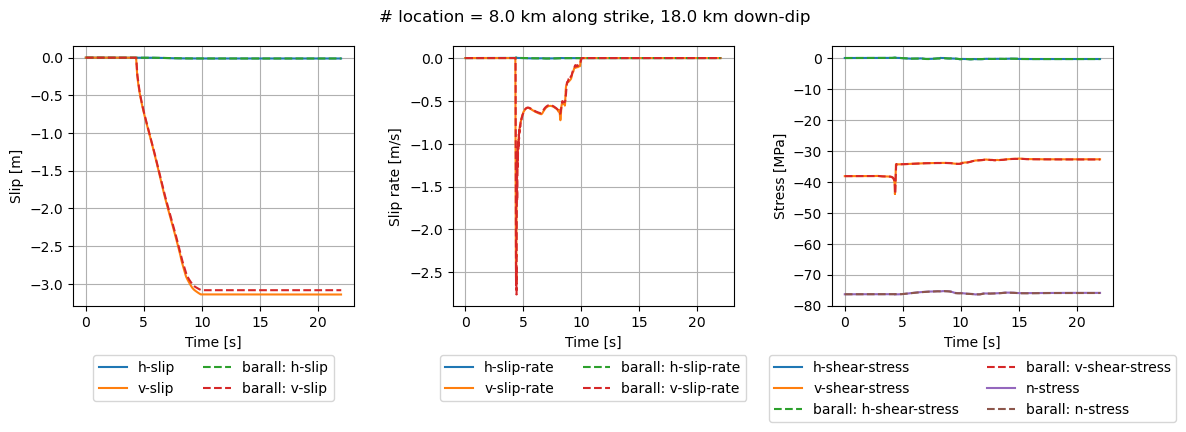

In [20]:
filenames = "fault*.csv"

files = glob.glob(os.path.join(output_folder, filenames))
for f in files:
    print(f)

    df_title = pd.read_csv(f, skiprows=8, nrows=1, sep=";", header=None) #arbitray separator
    title = df_title.iloc[0][0]
    
    df = pd.read_csv(f, sep="\s+", comment="#")

    f_barall = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/"+f[-19:-4]+".dat"
    print(f_barall)
    barall = pd.read_csv(f_barall, sep="\s+", comment="#") 

    # Create figure and subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))
    fig.suptitle(title)

    # Plot slip 
    ax1.plot(df["t"], df["h-slip"], label="h-slip")
    ax1.plot(df["t"], df["v-slip"], label="v-slip")
    ax1.plot(barall["t"], barall["h-slip"], label="barall: h-slip", linestyle="dashed")
    ax1.plot(barall["t"], barall["v-slip"], label="barall: v-slip", linestyle="dashed")
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Slip [m]")
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
    ax1.grid(True)

    # Plot slip rate
    ax2.plot(df["t"], df["h-slip-rate"], label="h-slip-rate")
    ax2.plot(df["t"], df["v-slip-rate"], label="v-slip-rate")
    ax2.plot(barall["t"], barall["h-slip-rate"], label="barall: h-slip-rate", linestyle="dashed")
    ax2.plot(barall["t"], barall["v-slip-rate"], label="barall: v-slip-rate", linestyle="dashed")
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Slip rate [m/s]")
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
    ax2.grid(True)

    # Plot stress
    ax3.plot(df["t"], df["h-shear-stress"], label="h-shear-stress")
    ax3.plot(df["t"], df["v-shear-stress"], label="v-shear-stress") 
    ax3.plot(barall["t"], barall["h-shear-stress"], label="barall: h-shear-stress", linestyle="dashed")
    ax3.plot(barall["t"], barall["v-shear-stress"], label="barall: v-shear-stress", linestyle="dashed") 
    ax3.plot(df["t"], df["n-stress"], label="n-stress")
    ax3.plot(barall["t"], barall["n-stress"], label="barall: n-stress", linestyle="dashed")
    ax3.set_xlabel("Time [s]")
    ax3.set_ylabel("Stress [MPa]")
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
    ax3.grid(True)

    # Adjust layout and display
    plt.tight_layout()
    fig.savefig(output_folder + "/" + f[-19:-4] + ".png", dpi=300)
    plt.show()